## Project : FoodSenseAI- Food image classification using Deep learning

### Import Necessary Libraries and Dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load and prepare the dataset
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

class_names = ds_info.features["label"].names

# Display basic dataset information
print(f"Dataset info: {ds_info.features}")
print(f"Class names: {class_names[:10]}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.8WLR2M_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.8WLR2M_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
Dataset info: FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})
Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


### Inspect a Sample from the Dataset


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class (tensor form): 43
    Class name (str form): fried_calamari
    


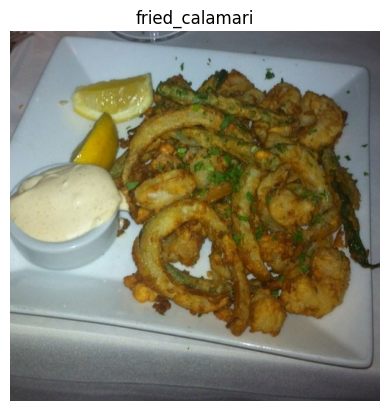

In [ ]:
# Take one sample from the training data
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

# Display the sample image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()


### Preprocess the Dataset

In [ ]:
# Preprocess function to resize and cast images
def preprocess_img(image, label, image_shape=224):
    image = tf.image.resize(image, [image_shape, image_shape])
    return tf.cast(image, tf.float32), label

# Apply preprocessing to the datasets
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


### Build the Model

In [ ]:
# Set mixed precision policy
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Define the model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()


16705208/16705208 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                           

### Train the Model

In [ ]:
# Define callbacks
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=0)

# Train the model
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                           experiment_name="efficientnetb0"),
                               model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientnetb0/20240727-235034
Epoch 1/3
2368/2368 [==============================] - 227s 89ms/step - loss: 1.7140 - accuracy: 0.5832 - val_loss: 1.1293 - val_accuracy: 0.6986
Epoch 2/3
2368/2368 [==============================] - 212s 88ms/step - loss: 1.1981 - accuracy: 0.6893 - val_loss: 1.0309 - val_accuracy: 0.7140
Epoch 3/3
2368/2368 [==============================] - 212s 89ms/step - loss: 1.0533 - accuracy: 0.7240 - val_loss: 0.9862 - val_accuracy: 0.7264


### Evaluate the Model

In [ ]:
# Evaluate the model
results = model.evaluate(test_data)
print(f"Evaluation results: {results}")


790/790 [==============================] - 62s 78ms/step - loss: 1.0010 - accuracy: 0.7278
Evaluation results: [1.000953197479248, 0.7278019785881042]


### Plot Training and Validation Loss/Accuracy:

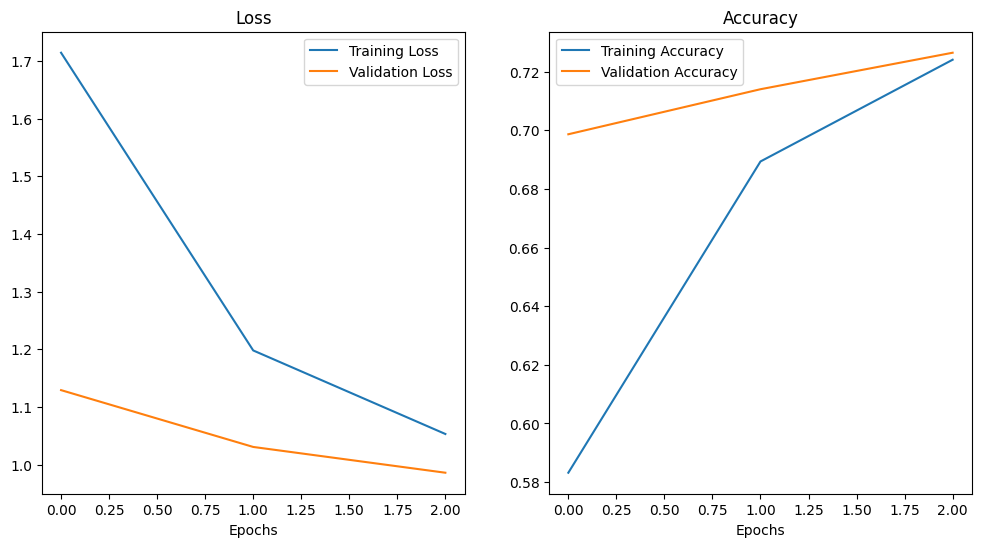

In [ ]:
#Visualize the training and validation loss and accuracy to see how well our model is performing over epochs.
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_loss_curves(history)



### Confusion Matrix:

1/1 [==============================] - 2s 2s/step


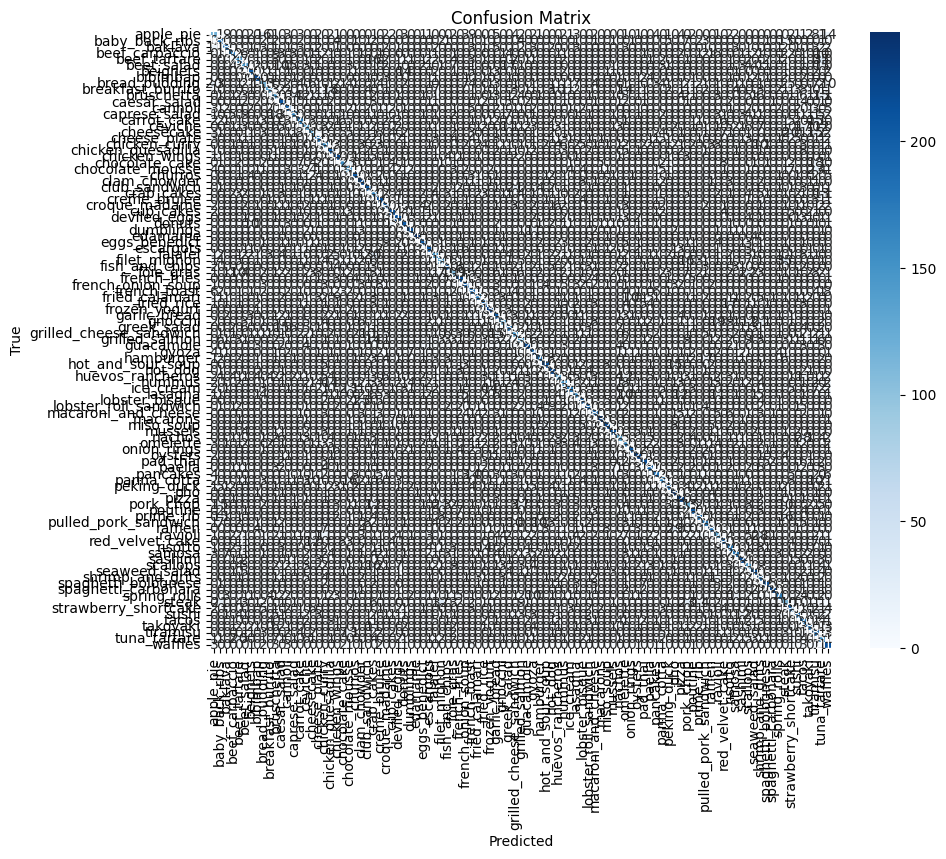

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Classification Report:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                         precision    recall  f1-score   support

              apple_pie       0.52      0.47      0.49       250
         baby_back_ribs       0.64      0.76      0.69       250
                baklava       0.84      0.73      0.78       250
         beef_carpaccio       0.81      0.70      0.75       250
           beef_tartare       0.59      0.58      0.58       250
             beet_salad       0.61      0.59      0.60       250
               beignets       0.84      0.82      0.83       250
               bibimbap       0.87      0.88      0.87       250
          bread_pudding       0.60      0.45      0.52       250
      breakfast_burrito       0.82      0.53      0.64       250
             bruschetta       0.60      0.60      0.60       250
           caesar_salad       0.66      0.84      0.74       250
                cannoli       0.81      0.77      0.79       250
          caprese_salad       0.77      0.66      0.71       250
            carrot_cake 

### Example Predictions:

1/1 [==============================] - 0s 34ms/step


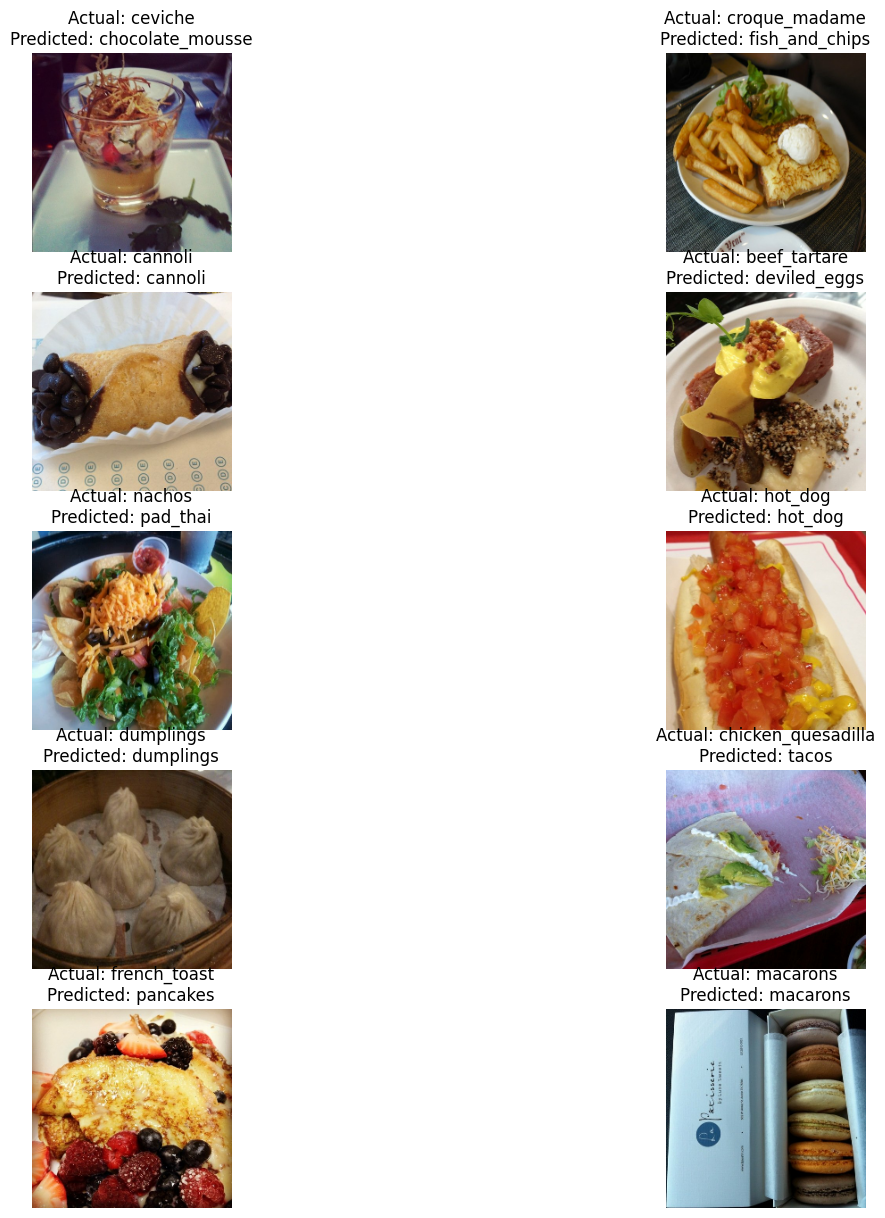

In [ ]:
import random

# Function to plot predictions
def plot_predictions(images, labels, preds, class_names, num=10):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}")
        plt.axis("off")
    plt.show()

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_data))

# Predict the labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot predictions
plot_predictions(test_images, test_labels, predicted_labels, class_names)


### Generate Predictions and Analyze Errors

In [ ]:
# Generate predictions and true labels
y_true = []
y_pred = []
y_pred_prob = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_prob.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Analyze wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]
wrong_pred_prob = y_pred_prob[wrong_predictions]
wrong_pred_true_labels = y_true[wrong_predictions]
wrong_pred_labels = y_pred[wrong_predictions]
sorted_indices = np.argsort(-np.max(wrong_pred_prob, axis=1))

for idx in sorted_indices[:10]:  # Display top 10 most wrong predictions
    true_label = class_names[wrong_pred_true_labels[idx]]
    predicted_label = class_names[wrong_pred_labels[idx]]
    prob = np.max(wrong_pred_prob[idx])
    print(f"True Label: {true_label}, Predicted: {predicted_label}, Probability: {prob}")


1/1 [==============================] - 0s 56ms/step
True Label: garlic_bread, Predicted: bruschetta, Probability: 0.9970671534538269
True Label: chicken_curry, Predicted: lobster_bisque, Probability: 0.9929503202438354
True Label: sashimi, Predicted: sushi, Probability: 0.9921848177909851
True Label: mussels, Predicted: oysters, Probability: 0.9918801188468933
True Label: fried_calamari, Predicted: onion_rings, Probability: 0.9897634983062744
True Label: scallops, Predicted: deviled_eggs, Probability: 0.9896608591079712
True Label: tuna_tartare, Predicted: beef_tartare, Probability: 0.987251877784729
True Label: donuts, Predicted: beignets, Probability: 0.9870461225509644
True Label: eggs_benedict, Predicted: sashimi, Probability: 0.9869261980056763
True Label: croque_madame, Predicted: garlic_bread, Probability: 0.986541748046875


### Fine-Tune the Model

In [ ]:
# Load and prepare for fine-tuning
model.load_weights(checkpoint_path)
for layer in model.layers:
    layer.trainable = True

early_stopping = EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1, min_lr=1e-7)
fine_tune_checkpoint_path = "fine_tune_checkpoints/"
fine_tune_model_checkpoint = ModelCheckpoint(fine_tune_checkpoint_path, save_best_only=True, monitor="val_loss")

# Fine-tune the model
history_fine_tune = model.fit(train_data,
                              epochs=100,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              callbacks=[create_tensorboard_callback("training_logs", "fine_tuning"),
                                         fine_tune_model_checkpoint,
                                         early_stopping,
                                         reduce_lr])


Saving TensorBoard log files to: training_logs/fine_tuning/20240728-001118
Epoch 1/100
2368/2368 [==============================] - 224s 94ms/step - loss: 0.9589 - accuracy: 0.7466 - val_loss: 0.9835 - val_accuracy: 0.7304 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 235s 98ms/step - loss: 0.8887 - accuracy: 0.7640 - val_loss: 0.9725 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 227s 95ms/step - loss: 0.8315 - accuracy: 0.7811 - val_loss: 0.9685 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 183s 76ms/step - loss: 0.7869 - accuracy: 0.7924 - val_loss: 0.9866 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.8018
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 181s 75ms/step - loss: 0.7480 - accuracy: 0.8018 - val_loss:

### Evalute Fine tuned model

In [ ]:
# Evaluate the fine-tuned model on the test data
results_fine_tune = model.evaluate(test_data)
print(f"Fine-tuned evaluation results: {results_fine_tune}")


790/790 [==============================] - 52s 65ms/step - loss: 0.9577 - accuracy: 0.7400
Fine-tuned evaluation results: [0.9576705694198608, 0.7399603724479675]


### Plot Training and Validation Curves

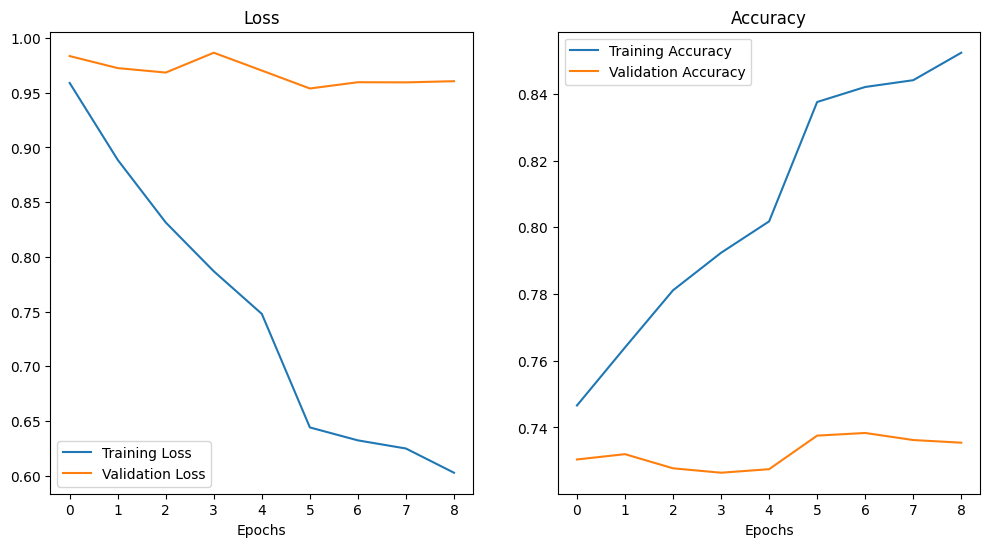

In [ ]:
# Function to plot loss and accuracy curves
def plot_loss_curves(history):
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

# Plot the curves for the fine-tuned model
plot_loss_curves(history_fine_tune)


### Generate Confusion Matrix

1/1 [==============================] - 0s 37ms/step


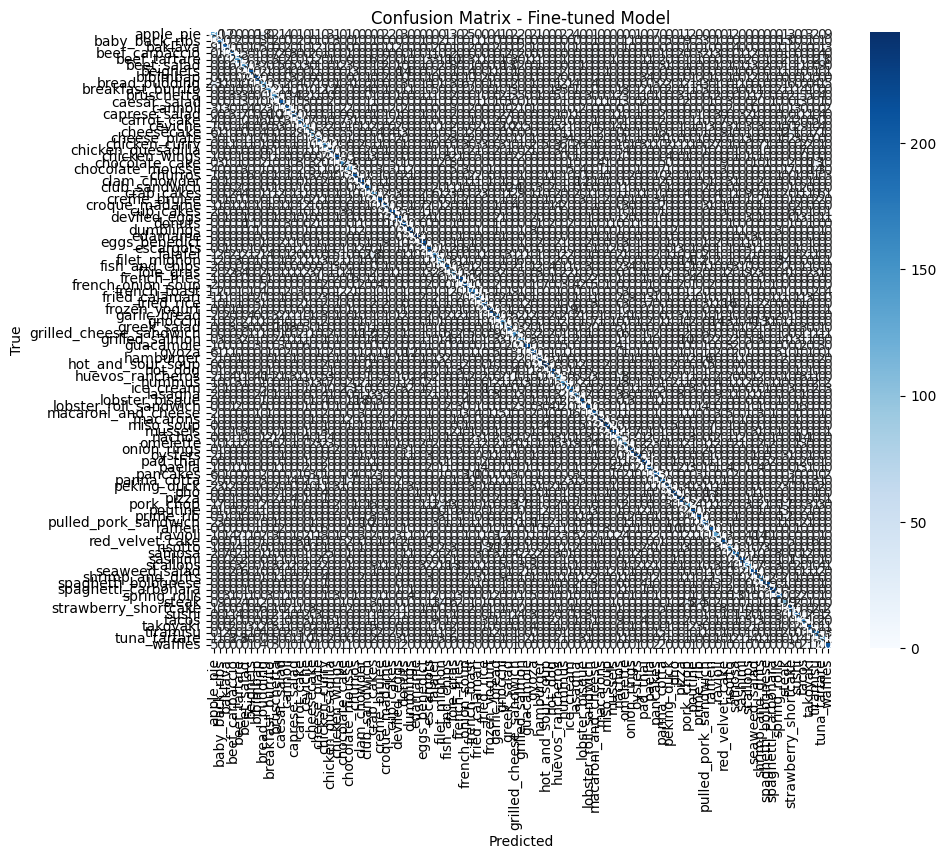

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned Model')
plt.show()


### Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))


                         precision    recall  f1-score   support

              apple_pie       0.50      0.53      0.52       250
         baby_back_ribs       0.77      0.72      0.74       250
                baklava       0.80      0.78      0.79       250
         beef_carpaccio       0.75      0.76      0.76       250
           beef_tartare       0.63      0.61      0.62       250
             beet_salad       0.60      0.63      0.62       250
               beignets       0.83      0.81      0.82       250
               bibimbap       0.84      0.88      0.86       250
          bread_pudding       0.54      0.51      0.52       250
      breakfast_burrito       0.74      0.62      0.67       250
             bruschetta       0.65      0.61      0.63       250
           caesar_salad       0.75      0.80      0.78       250
                cannoli       0.80      0.80      0.80       250
          caprese_salad       0.70      0.74      0.72       250
            carrot_cake 

### Example Predictions

1/1 [==============================] - 0s 47ms/step


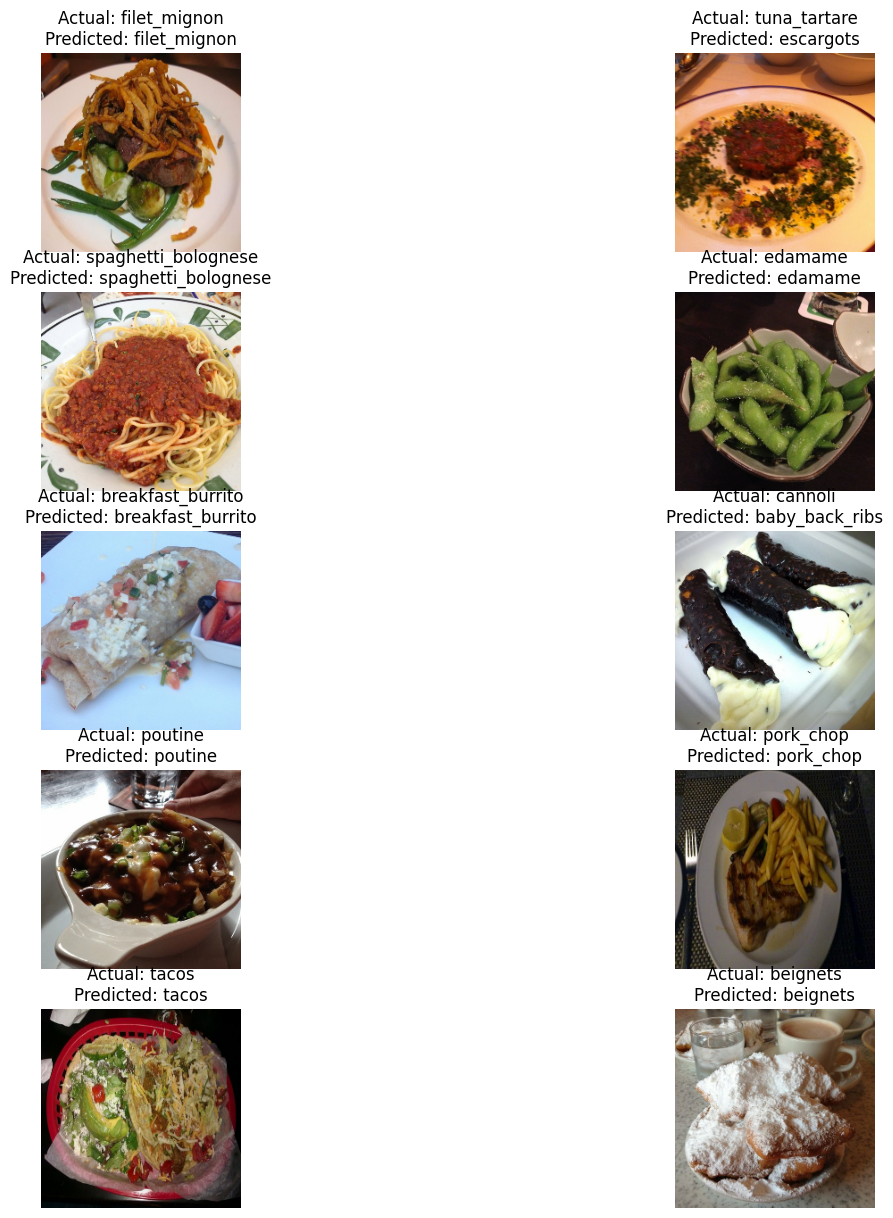

In [ ]:
# Function to plot predictions
def plot_predictions(images, labels, preds, class_names, num=10):
    plt.figure(figsize=(15, 15))
    for i in range(num):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}")
        plt.axis("off")
    plt.show()

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_data))

# Predict the labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot predictions
plot_predictions(test_images, test_labels, predicted_labels, class_names)


### Misclassification Analysis

In [ ]:
# Assuming y_true, y_pred, and y_pred_prob are already populated correctly
y_true = []
y_pred = []
y_pred_prob = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_prob.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Analyze wrong predictions
wrong_predictions = np.where(y_pred != y_true)[0]
wrong_pred_prob = y_pred_prob[wrong_predictions]
wrong_pred_true_labels = y_true[wrong_predictions]
wrong_pred_labels = y_pred[wrong_predictions]
sorted_indices = np.argsort(-np.max(wrong_pred_prob, axis=1))

for idx in sorted_indices[:10]:  # Display top 10 most wrong predictions
    true_label = class_names[wrong_pred_true_labels[idx]]
    predicted_label = class_names[wrong_pred_labels[idx]]
    prob = np.max(wrong_pred_prob[idx])
    print(f"True Label: {true_label}, Predicted: {predicted_label}, Probability: {prob}")


1/1 [==============================] - 0s 27ms/step
True Label: garlic_bread, Predicted: bruschetta, Probability: 0.9993159770965576
True Label: sashimi, Predicted: sushi, Probability: 0.9988094568252563
True Label: paella, Predicted: pad_thai, Probability: 0.9974716901779175
True Label: mussels, Predicted: oysters, Probability: 0.9971956014633179
True Label: fried_rice, Predicted: pad_thai, Probability: 0.9970757961273193
True Label: scallops, Predicted: deviled_eggs, Probability: 0.9968885779380798
True Label: fried_calamari, Predicted: onion_rings, Probability: 0.9963233470916748
True Label: samosa, Predicted: spring_rolls, Probability: 0.996126115322113
True Label: chicken_curry, Predicted: lobster_bisque, Probability: 0.9957226514816284
True Label: donuts, Predicted: beignets, Probability: 0.9956362843513489


### Save the Fine tuned model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/models/Fine_tuned_food101_model_JULY27'

model.save(model_save_path,include_optimizer=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

### Make Predictions on New Images

1/1 [==============================] - 2s 2s/step


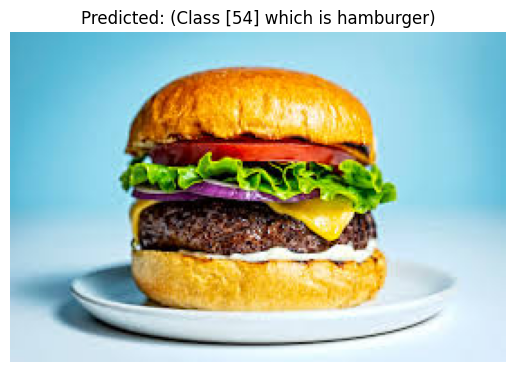

In [ ]:

from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path to the image you want to predict
image_path = '/content/download.jpeg'

# Open the image using PIL
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Convert the numpy array to a TensorFlow tensor
image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)

# Add a batch dimension
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Define the preprocessing function
def preprocess_img(image, image_shape=224):
    image = tf.image.resize(image, [image_shape, image_shape])
    return tf.cast(image, tf.float32)

# Preprocess the image
preprocessed_image = preprocess_img(image_tensor)

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/models/Fine_tuned_food101_model_JULY27')

# Predict the class of the new image
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
#print(f'Predicted class: {predicted_class[0]+1}')

predicted_class_name = class_names[predicted_class[0]]
#print(f'Predicted class name: {pridicted_class_name}')

# Optionally, display the original and preprocessed images
Image.fromarray(np.uint8(image_array)).show()
Image.fromarray(np.uint8(preprocessed_image[0].numpy())).show()

plt.imshow(image)
plt.title(f"Predicted: (Class {predicted_class + 1} which is {predicted_class_name})")
plt.axis("off")
plt.show()

In [ ]:
class_names = ["apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
               "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito",
               "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake",
               "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla",
               "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder",
               "club_sandwich", "crab_cakes", "creme_brulee", "croque_madame", "cup_cakes",
               "deviled_eggs", "donuts", "dumplings", "edamame", "eggs_benedict",
               "escargots", "falafel", "filet_mignon", "fish_and_chips", "foie_gras",
               "french_fries", "french_onion_soup", "french_toast", "fried_calamari", "fried_rice",
               "frozen_yogurt", "garlic_bread", "gnocchi", "greek_salad", "grilled_cheese_sandwich",
               "grilled_salmon", "guacamole", "gyoza", "hamburger", "hot_and_sour_soup",
               "hot_dog", "huevos_rancheros", "hummus", "ice_cream", "lasagna",
               "lobster_bisque", "lobster_roll_sandwich", "macaroni_and_cheese", "macarons", "miso_soup",
               "mussels", "nachos", "omelette", "onion_rings", "oysters",
               "pad_thai", "paella", "pancakes", "panna_cotta", "peking_duck",
               "pho", "pizza", "pork_chop", "poutine", "prime_rib",
               "pulled_pork_sandwich", "ramen", "ravioli", "red_velvet_cake", "risotto",
               "samosa", "sashimi", "scallops", "seaweed_salad", "shrimp_and_grits",
               "spaghetti_bolognese", "spaghetti_carbonara", "spring_rolls", "steak", "strawberry_shortcake",
               "sushi", "tacos", "takoyaki", "tiramisu", "tuna_tartare",
               "waffles"]

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
import zipfile

# Define the paths to your files
notebook_path = 'path/to/your/model.ipynb'
script_path = 'path/to/your/script.py'

# Define the name of the zip file
zip_filename = 'FoodSenseAI_code_files.zip'

# Create a ZipFile object
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add the notebook to the zip file
    zipf.write(notebook_path, 'model.ipynb')
    # Add the script to the zip file
    zipf.write(script_path, 'script.py')

print(f'Created zip file: {zip_filename}')